In [1]:
import pandas as pd
import numpy as np
#Packages below are required only for visualization
import matplotlib.pyplot as plt
from scipy import stats

### Rergression estimator of the target class area for stratified random sampling, from Tyukavina et al. (in review) "Practical global sampling methods for estimating area and map accuracy of land cover and change classes", Appendix A2.2.

#### Example of input data

In [2]:
#Read strata info table with columns:
#"Stratum" - stratum ID, 1 - nstrata;
#"Count" - total number of units (pixels, polygons) in each stratum;
#"Xh" - stratum-specific mean of the values of auxiliary class (calculated accross all units in the stratum);
#(optional, might be needed to convert estimates to % of total area)"Area" - stratum area in km2 or any other area units consistent with units of yi;
strata = pd.read_csv('A2.2.Strata_info.txt', sep = '\t')

In [3]:
strata.head().style.hide(axis="index")

Stratum,Area,Count,Xh
1,331763.613000,13314,0.000000
2,368042.987900,14767,0.099169
3,88783.438150,3563,1.114164


In [4]:
#Read sample interpretation table with columns:
#"Stratum" - stratum ID, 1 - nstrata;
#"yi" - area of the target class in sample unit i,derived from sample interpretation (reference classification);
#"yi" should be in the same units as Ah;
#"xi" - value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
#mean spectral index value within sample unit); 
#"xi" could be in any units matching X

data = pd.read_csv('A2.2.Sample_data.txt', sep ='\t')

In [5]:
#Merge data table with sample info table
data = data.merge(strata)
data = data.rename(columns = {'Area':'Ah', 'Count':'Nh'})

In [6]:
data.head().style.hide(axis="index")

Stratum,xi,yi,Ah,Nh,Xh
3,0.879058,1.002733,88783.438150,3563,1.114164
3,1.007511,1.069959,88783.438150,3563,1.114164
3,0.738058,0.449162,88783.438150,3563,1.114164
3,1.241311,1.061714,88783.438150,3563,1.114164
3,0.569801,0.565049,88783.438150,3563,1.114164


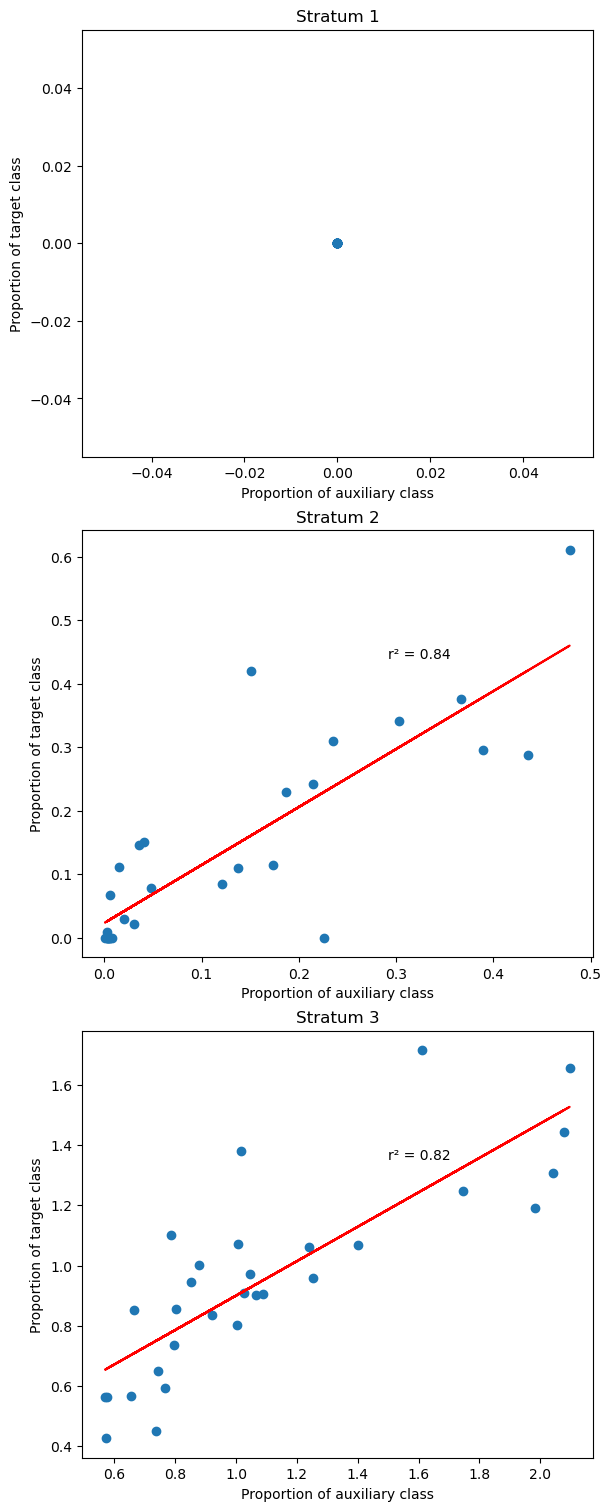

In [7]:
#Visualize linear regression between y and x in each stratum

fig, axes = plt.subplots(3,figsize=(6,15), constrained_layout=True)
nstrata = data.Stratum.max()

for stratum in range(nstrata):
    datasubs = data[data['Stratum']==stratum+1]
    axes[stratum].scatter(datasubs.xi,datasubs.yi)
    axes[stratum].set_xlabel('Proportion of auxiliary class')
    axes[stratum].set_ylabel('Proportion of target class')
    axes[stratum].set_title(f'Stratum {stratum+1}')

    if datasubs.yi.max()>0 and datasubs.xi.max()>0:
        linreg = stats.linregress(datasubs.xi, datasubs.yi)
        axes[stratum].plot(datasubs.xi, linreg.intercept + linreg.slope*datasubs.xi, 'r')
        axes[stratum].text(0.6,0.7, 'r² = %0.2f' % linreg.rvalue, transform=axes[stratum].transAxes)
    
plt.show()

#### Functions to produce regression estimate of target class area and its standard error

In [8]:
def estimate_area_reg(df: pd.DataFrame) -> float:
    """ 
    Function to produce regression estimator of target class area from sample refernce values 
    for equal probability sampling (stratified).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" - area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    "xi" - value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
    mean spectral index value within sample unit); xi could be in any units matching Xh.
    "Nh" (number of units in each stratum h)
    "Xh" (mean of the auxiliary class values, calculated accross all units in stratum h)
    ~~~
    Returns estimated target class area in units of yi
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix A2.2, equations 44-46
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 46
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equation 45
    Xh = ByStratum['Xh'].median()
    Nh = ByStratum['Nh'].median()
    Yh = Nh * (ByStratum['yi'].mean() + bh * (Xh - ByStratum['xi'].mean()))
    
    #Equation 45
    area = Yh.sum()

    return area

In [9]:
estimate_area_reg(data)

5120.712152555612

In [10]:
def estimate_area_SE_reg(df: pd.DataFrame) -> float:
    """ 
    Function to estimate SE of the regression estimate of target class area from sample refernce values 
    for equal probability sampling (stratified).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" - area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    "xi" - value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
    mean spectral index value within sample unit); xi could be in any units matching Xh.
    "Nh" (number of units in each stratum h)
    "Xh" (mean of the auxiliary class values, calculated accross all units in stratum h)
    ~~~
    Returns estimated target class area in units of yi
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix A2.2, equation 46-47
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(y-ymean)^2'] = df1['y-ymean'] * df1['y-ymean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 46
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equation 47
    Nh = ByStratum['Nh'].median()
    nh = ByStratum['yi'].count()
    ForVar = (ByStratum['(y-ymean)^2']).sum() - bh * bh * (ByStratum['(x-xmean)^2']).sum()
    Var = ForVar * Nh * Nh * (1 - nh/Nh) / (nh * (nh - 2)) 
    SumVar = Var.sum()
    SE = np.sqrt(SumVar)

    return SE

In [11]:
estimate_area_SE_reg(data)

267.28810991220274